Escolha da resnet18 pois entre as possíveis, é a que possui número menor de parâmetros
Teste com a resnet18 sem nenhuma transformação e aumentada a quantidade de épocas de treino
- primeiro treino: 50 épocas
  * acc = 0,96, loss = 0,093

- segundo treino: 100 épocas e sem a normalização da visualização
  * acc = 0,99, loss = 0,01

- terceiro treino: 100 épocas e sem a normalização da visualização, adaptação do lightning pra plotar a confusion matrix
  * acc de multiclass: 0,83
  * na confusion matrix, apenas uma amostra foi classificada errada -> overfitting com certeza

In [ ]:
!pip install pytorch_lightning -qqq
import pytorch_lightning
!pip install neptune
import neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
#run = neptune.init_run(
#    project="lais-oliveira/IA901-Resnet1",
#    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiYmYzNTE1NS0zNzc4LTRmNTctOTIwZC0xNTEyZTRiMmFhMzEifQ==",
#) 

https://app.neptune.ai/lais-oliveira/IA901-Resnet1/e/IAR1-3


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)

1

In [ ]:
transform=transforms.Compose([
        transforms.ToTensor()
])

In [ ]:
dataset0=datasets.ImageFolder(root='/content/gdrive/MyDrive/IA901A_Projeto/data/processed/kaggle/Alzheimer_s Dataset',transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

6404
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
4


In [ ]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = '/content/gdrive/MyDrive/IA901A_Projeto/data/processed/kaggle/Alzheimer_s Dataset'
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [ ]:
datamodule = DataModule()
datamodule.setup()

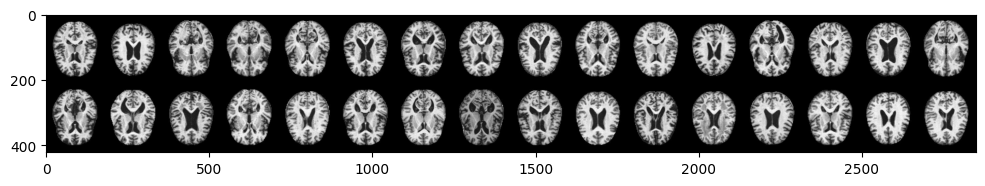

In [ ]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

#inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   #std=[1/0.229,1/0.224,1/0.225])
#im=inv_normalize(im)

#plt.figure(figsize=(12,12))
#plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

batch_size = 32

class MyModel(LightningModule):

    def __init__(self):
        num_classes = len(class_names)
        super().__init__()
        self.model = models.resnet18(pretrained=True)        
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs,len(class_names))

        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]

        output = self.val_metrics(pred, y)
        self.log_dict(output)
        
        
        #self.log("train_loss", loss)
        #self.log("train_acc", acc)

        #run["train/loss"].append(loss)
        #run["train/acc"].append(acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]

        output = self.val_metrics(pred, y)
        self.log_dict(output)

        #self.log("val_loss", loss)
        #self.log("val_acc", acc)
        #run["val/loss"].append(loss)
        #run["val/acc"].append(acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]

        if (batch_idx == 0):
            self.all_labels = y.clone()
            self.all_preds = pred.clone()
        else:
            self.all_labels = torch.cat((self.all_labels, y))
            self.all_preds = torch.cat((self.all_preds, pred))
        
        #self.log("test_loss", loss)
        #self.log("test_acc", acc)
        #run["test/loss"].append(loss)
        #run["test/acc"].append(acc)

        output = self.val_metrics(pred, y)
        self.log_dict(output)

In [ ]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = MyModel()
    trainer = pl.Trainer(max_epochs=100)
    trainer.fit(model, datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet           | 11.2 M
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.714    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
metrics = trainer.test(dataloaders=test_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_2/checkpoints/epoch=99-step=16100.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_2/checkpoints/epoch=99-step=16100.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  val_MulticlassAccuracy   │     0.83027583360672      │
│  val_MulticlassPrecision  │    0.8304492831230164     │
│   val_MulticlassRecall    │     0.83027583360672      │
└───────────────────────────┴───────────────────────────┘

In [ ]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/lais-oliveira/IA901-Resnet/e/IAR-3/metadata


In [ ]:
print(class_names)

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


[Text(0, 0.5, 'MildDemented'),
 Text(0, 1.5, 'ModerateDemented'),
 Text(0, 2.5, 'NonDemented'),
 Text(0, 3.5, 'VeryMildDemented')]

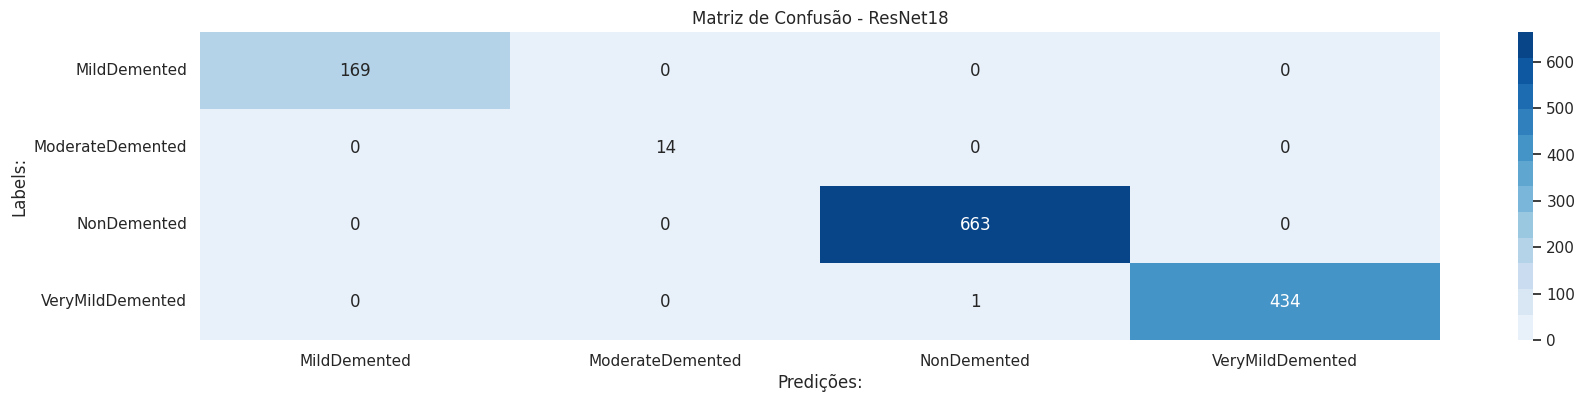

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

ax = plt.subplot()
cm = confusion_matrix(model.all_labels.cpu(), model.all_preds.cpu())

sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(20, 4)})
colormap = sns.color_palette("Blues",12)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=colormap)  

# labels, title and ticks
ax.set_xlabel('Predições:')
ax.set_ylabel('Labels:')
ax.set_title('Matriz de Confusão - ResNet18'); 
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names, rotation=0)